<a href="https://colab.research.google.com/github/Sofigam00s/Aprendizaje-Automatico-2-IA/blob/main/Gamallo_TP1_AA2_mnist_consigna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico nro 1 de AA2.

**Sofía Antonia Gamallo**

**DNI:42432866**


Resolver las consignas comentando el código fuente, indicando desde dónde fue extraido o generado.

Justificar cada paso realizado.

Publique enlace público a su notebook en google colab y también enlace a su repositorio github de la materia.








# Carga de librerías

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms


## 1- Usar pytorch para crear una clase que herede de dataset para crear un dataset propio.

El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original


In [ ]:
# prompt: usar pytorch para crear una clase que herede de dataset para crear un dataset propio. El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

class MNISTSubset(Dataset):
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[0, 1]):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform)
        self.target_classes = target_classes
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets) if target in self.target_classes]
        self.targets = [self.mnist_dataset.targets[i] for i in self.indices]

        # Remap targets to 0 and 1
        self.targets = [self.target_classes.index(target) for target in self.targets]
        self.targets = torch.tensor(self.targets)


    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, _ = self.mnist_dataset[self.indices[idx]] # Get image from original MNIST dataset
        target = self.targets[idx] # Get corresponding remapped target

        return image, target





En el siguiente ejemplo, se eligen las clases 3 y 8.
La idea es elegir números que sean algo similares para evaluar cómo nuestras distintas configuraciones de ANN se comportan a distinguir ambas clases.

Puede elegir por ejemplo:

* 3 y 8
* 7  y 4
* 0 y 8
* 6 y 8
* 2 y 4
* 5 y 6

### Elija pronto cuáles clases quiere distinguir y postee en el foro.



> Voy a utilizar las clases **5 y 6**



In [ ]:

transform = transforms.Compose([transforms.ToTensor()])
mnist_subset = MNISTSubset(train=True, transform=transform, target_classes=[5, 6])


## 2- Usar el dataset anterior para crear una red neuronal profunda en Pytorch para aprender un clasificador binario.

Debe contemplar tres tipos de configuraciones:

* 2.1 Una donde se muestre subajuste (underfitting).
* 2.2 Una donde considere que su funcionamiento es aceptable
* 2.3 Una donde demuestre un comportamiento de overfitting o sobreajuste.

Puede utilizar sólo nn.Linear y funciones de activación. Es sólo las redes neuronales que ya aprendieron con varias capas / unidades ocultas y funciones de activación.




## Desarrollo

Para empezar a realizar las consignas, me voy a basar en el trabajo n°4 de **Aprendizaje Automático 1** donde vimos las redes neuronales con *scikit-learn* y trabajamos los diferentes resultados que puede obtener una red neuronal.

### 2.1 Red que subajusta

Teniendo en cuenta que una red que subajuste significa que ''no puede aprender correctamente'' de los datos, voy a crearla con una sola capa lineal y sin ninguna neurona, ni tampoco funciones de activacion o regulación, para que su rendimiento sea bastante malo.

In [ ]:
class Modelo_NN_subajusta(nn.Module):
    def __init__(self):
        super(Modelo_NN_subajusta, self).__init__()
        self.flatten = nn.Flatten()
        self.layer_1 = nn.Linear(784, 1)
        self.sigmoid = nn.Sigmoid() # Add sigmoid activation

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer_1(x)
        x = self.sigmoid(x) # Apply sigmoid
        return x


>El motivo por el cual hice una red tan simple es para poder tener una comparación clara en los resultados de subajuste, sobreajuste y uno óptimo.



### 2.2 Red que sobre ajusta

Para esta red voy a hacer lo contrario a la de subajuste, quiero que aprenda los datos al punto de memorizarlos, así va a generar un rendimiento muy alto en su entrenamiento pero a la hora de que tenga datos nuevos (de testeo) no va a poder generalizarlos muy bien, dando como resultado una gran diferencia entre la exactitud de entrenamiento y la de testeo.

Entonces esta red va a tener muchas capas y muchas neuronas, sin ninguna regulación, para que memorice los datos y aprenda incluso el ruido de ellos.



In [ ]:
class Modelo_NN_SobreAjustado(nn.Module):
    def __init__(self):
        super(Modelo_NN_SobreAjustado, self).__init__()
        self.flatten = nn.Flatten()
        self.layer_1 = nn.Linear(784, 400)
        self.layer_2 = nn.Linear(400, 200) # Corrected input size
        self.layer_3 = nn.Linear(200, 100)
        self.layer_4 = nn.Linear(100, 50) # Corrected input size
        self.output = nn.Linear(50, 1) # Corrected input size


    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.layer_1(x))
        x = torch.relu(self.layer_2(x))
        x = torch.relu(self.layer_3(x))
        x = torch.relu(self.layer_4(x))
        x = torch.sigmoid(self.output(x))
        return x


> Como se puede ver, esta red tiene muchas capas y muchas neuronas (4 capas ocultas que comienza con 400 neuronas y van disminuyendo hasta la última capa, que devuelve una sola salida). Además la función de activación ReLU ayuda a que la red aprenda patrones muy específicos y todo en conjunto debería dar como resultado un sobreajuste.




### 2.3 MLP aceptable

Al realizar las redes anteriores, busqué parámetros extremos para crear un subajuste y un sobreajuste a propósito.

Ahora para encontrar un resultado más aceptable, voy a buscar un balance en los parámetros y ayudarme de funciones de regulación que le permitan a la red tener un rendimiento más óptimo.

Para ello voy a empezar con 2 capas ocultas y menos cantidad de neuronas. También le voy a agregar las funciones ReLU y sigmoid que son las más conocidas para mejorar la efiencia de la red. Por último, Copilot me recomendó la función de regulación Dropout que ayuda a reducir el sobreajuste y me parece ideal para buscar un buen resultado.

In [ ]:
class Modelo_NN_aceptable(nn.Module):
    def __init__(self):
        super(Modelo_NN_aceptable, self).__init__()
        self.flatten = nn.Flatten()
        self.layer_1 = nn.Linear(784, 196)
        self.layer_2 = nn.Linear(196, 98)
        self.output = nn.Linear(98, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.layer_1(x))
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x)) # Apply sigmoid
        return x



> Si bien estoy probando los parámetros todavía 'a ciegas' espero que con esta confguración el rendimiento mejore a comparación de las redes anteriores.




## 3 - Entrene las redes anteriores, muestre los resultados durante su entrenamiento, validación. Indique las métricas utilizadas. Justifique.

A este punto del trabajo, me estoy ayudando de este tutorial que esta hecho en español:

https://phuijse.github.io/MachineLearningBook/contents/neural_networks/torch-training.html

Y también con ayuda de Copilot, para adaptar el tutorial a lo que necesito.

### 3.1 Cargue los datos, divida los conjuntos de datos

En este caso, me estoy guiando con la parte 13.4 **Entrenamiento por minibaches** donde primero carga los datos y los divide en train y test, pero también usa una porción de los datos para la *validación*, que se usa para monitorear el rendimiento durante el entrenamiento y también poder aplicar técinas como el early stopping.

Así que primero quiero saber la cantidad de ejemplos del dataset creado al principio (con las clases 5 y 6 en mi caso) para entender un poco mejor la división de los datos.

In [ ]:
print("Cantidad de ejemplos en el dataset:", len(mnist_subset))


Cantidad de ejemplos en el dataset: 11339


>Le pedí a Copilot que me cargue los datos y los divida teniendo en cuenta esta cantidad de ejemplo:





In [ ]:
#Código proporcionado por Copilot

from torch.utils.data import random_split, DataLoader

# División en proporciones: 80% entrenamiento, 10% validación, 10% testeo
train_size = int(0.8 * 11339)   # ≈ 9071
valid_size = int(0.1 * 11339)   # ≈ 1133
test_size = 11339 - train_size - valid_size  # ≈ 1135

train_set, valid_set, test_set = random_split(
    mnist_subset,
    [train_size, valid_size, test_size],
    generator=torch.Generator().manual_seed(1234)  # reproducibilidad
)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)


### 3.2 Entrene cada modelo.

Para este punto voy a utilizar una parte del siguiente tutorial:

https://www.datacamp.com/es/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch

Me gustó este tutorial porque en la parte de entrenar el modelo elige la función de entropía cruzada binaria que es ideal para la clasificación de las clases 5 y 6.




> Como son tres modelos los que hay que entrenar, los voy a agrupar en un diccionario para poder usarlos en un buclue que recorra cada modelo y luego pase al bucle de las épocas:



In [ ]:
modelos = {
    "subajusta": Modelo_NN_subajusta(),
    "sobreajusta": Modelo_NN_SobreAjustado(),
    "aceptable": Modelo_NN_aceptable()
}



> Usando el mismo código de la página de datacamp, le pedí ayuda a Copilot para adaptarlo a mi trabajo y usar el diccionario para crear el primer bucle:



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 100
resultados = {}

for nombre, modelo in modelos.items():
    print(f"\nEntrenando el modelo: {nombre}")
    modelo.to(device)

    loss_fn = nn.BCELoss()
    optimizer = optim.SGD(modelo.parameters(), lr=0.01)
    train_loss_values = []
    valid_loss_values = []

    for epoch in range(num_epochs):
        # Entrenamiento
        modelo.train()
        epoch_train_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device).float().unsqueeze(-1)
            optimizer.zero_grad()
            pred = modelo(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * X.size(0)
        train_loss_values.append(epoch_train_loss / len(train_set))

        # Validación
        modelo.eval()
        epoch_valid_loss = 0
        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device).float().unsqueeze(-1)
                pred_valid = modelo(X_valid)
                loss_valid = loss_fn(pred_valid, y_valid)
                epoch_valid_loss += loss_valid.item() * X_valid.size(0)
        valid_loss_values.append(epoch_valid_loss / len(valid_set))

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss_values[-1]:.4f}, Valid Loss: {valid_loss_values[-1]:.4f}')


    resultados[nombre] = {"train_loss": train_loss_values, "valid_loss": valid_loss_values}
    print(f"Entrenamiento listo para: {nombre}")


Entrenando el modelo: subajusta
Epoch [10/100], Train Loss: 0.0863, Valid Loss: 0.0846
Epoch [20/100], Train Loss: 0.0742, Valid Loss: 0.0740
Epoch [30/100], Train Loss: 0.0686, Valid Loss: 0.0689
Epoch [40/100], Train Loss: 0.0649, Valid Loss: 0.0650
Epoch [50/100], Train Loss: 0.0621, Valid Loss: 0.0629
Epoch [60/100], Train Loss: 0.0599, Valid Loss: 0.0608
Epoch [70/100], Train Loss: 0.0581, Valid Loss: 0.0597
Epoch [80/100], Train Loss: 0.0565, Valid Loss: 0.0586
Epoch [90/100], Train Loss: 0.0551, Valid Loss: 0.0575
Epoch [100/100], Train Loss: 0.0538, Valid Loss: 0.0565
Entrenamiento listo para: subajusta

Entrenando el modelo: sobreajusta
Epoch [10/100], Train Loss: 0.0509, Valid Loss: 0.0543
Epoch [20/100], Train Loss: 0.0238, Valid Loss: 0.0323
Epoch [30/100], Train Loss: 0.0099, Valid Loss: 0.0232
Epoch [40/100], Train Loss: 0.0031, Valid Loss: 0.0246
Epoch [50/100], Train Loss: 0.0013, Valid Loss: 0.0175
Epoch [60/100], Train Loss: 0.0007, Valid Loss: 0.0195
Epoch [70/100],

### 3.3 Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo.

Muestre y compare los resultados de cada modelo entre conjuntos de entrenamiento y testeo. Escriba sus conclusiones y pasos realizados.



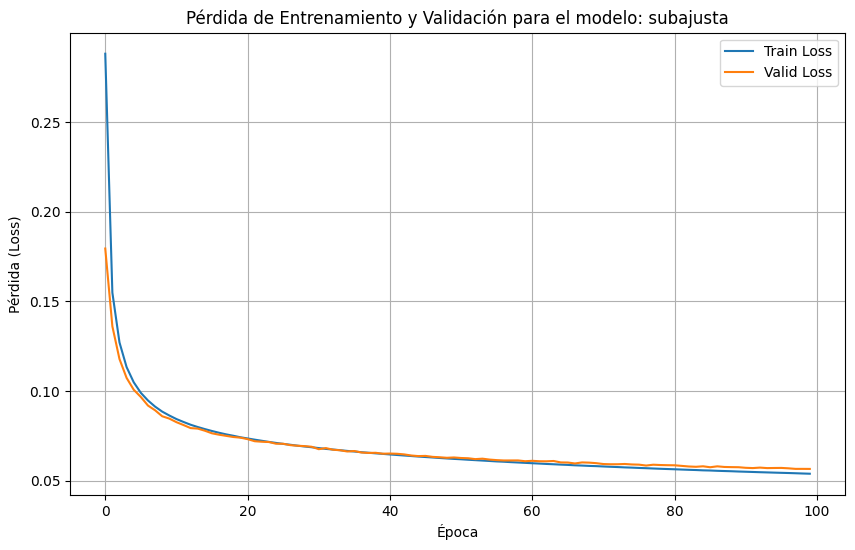

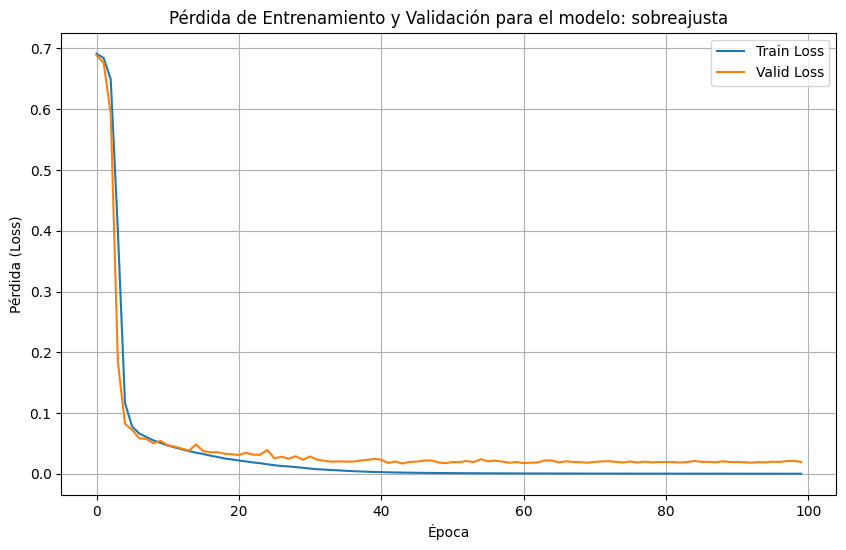

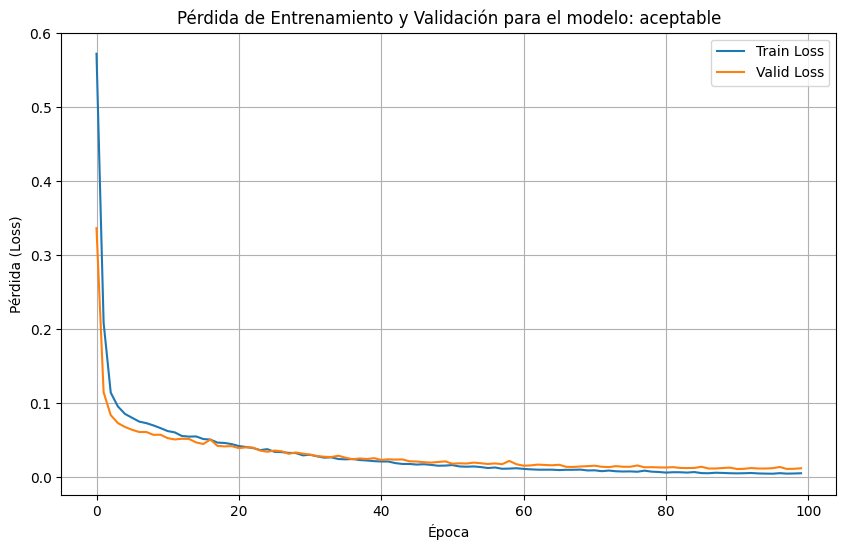

In [ ]:
# prompt: Generar un gráfico de pérdida y épocas en train y test para cada modelo
import matplotlib.pyplot as plt

for nombre, data in resultados.items():
    plt.figure(figsize=(10, 6))
    plt.plot(data["train_loss"], label="Train Loss")
    plt.plot(data["valid_loss"], label="Valid Loss")
    plt.title(f"Pérdida de Entrenamiento y Validación para el modelo: {nombre}")
    plt.xlabel("Época")
    plt.ylabel("Pérdida (Loss)")
    plt.legend()
    plt.grid(True)
    plt.show()



*   **Gráfico de subajuste:** la pérdida baja más lento a comparación de los otros modelos, y también tiene un mayor valor de pérdida al final.
*   **Gráfico de sobreajuste:** la pérdida baja mas rápido y llega al punto de casi el 0% en el entrenamiento. Sin embargo, la curva de testeo no baja tanto y genera el sobreajuste.
*   **Gráfico aceptable:** Las curvas son muy similares al gráfico de sobreajuste, y en este caso la pérdida también disminuye casi al 0%, pero las curvas no se separan por lo tanto no se genera un sobreajuste.


Los tres modelos a simple vista son muy similares ya que los valores de pérdida y el comportamiento de las curvas no diferen mucho unas de otras. Sin embargo sí se puede decir que las redes echas intencionamelte para generar rendimientos con subajuste, sobreajuste y aceptable cumplieron su objetivo, aunque no de manera exagerada.




Evaluando el modelo: subajusta


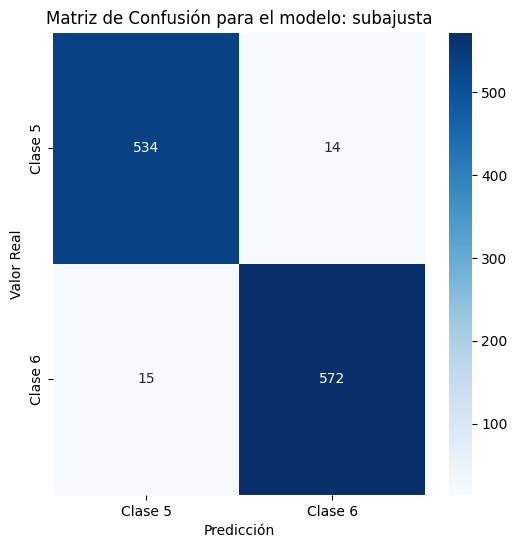


Evaluando el modelo: sobreajusta


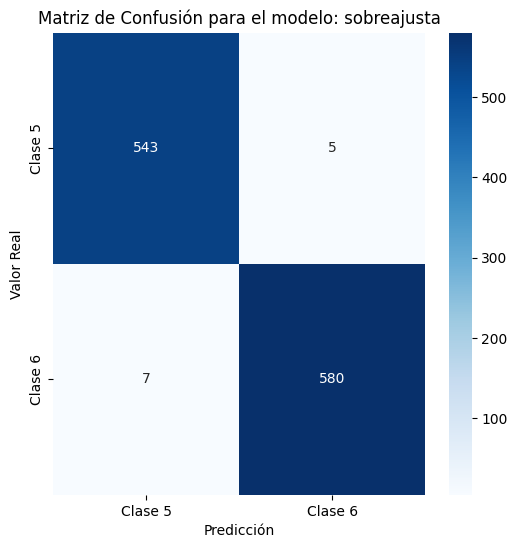


Evaluando el modelo: aceptable


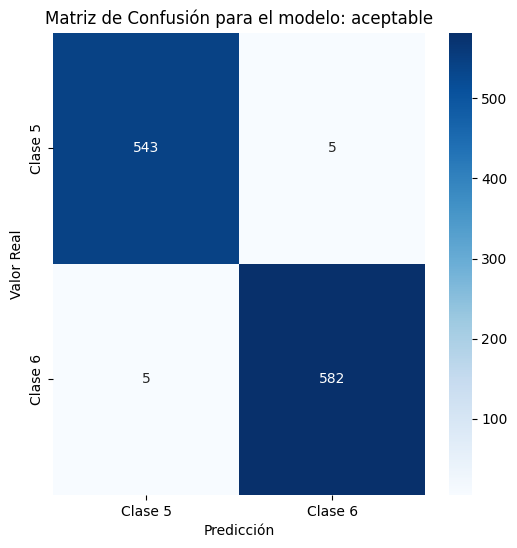

In [ ]:
# prompt: generar una matriz de confusión para cada modelo
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for nombre, modelo in modelos.items():
    print(f"\nEvaluando el modelo: {nombre}")
    modelo.to(device)
    modelo.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device).float().unsqueeze(-1)
            pred_test = modelo(X_test)
            predicted_classes = (pred_test > 0.5).float()

            all_preds.extend(predicted_classes.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 5', 'Clase 6'], yticklabels=['Clase 5', 'Clase 6'])
    plt.title(f'Matriz de Confusión para el modelo: {nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

Las tres matrices tuvieron un resultado muy similar, pero el modelo de subajuste tuvo un poco más de errores que los demás. De igual manera, considero que tienen un desempeño aceptable.

In [ ]:
# prompt: generar un reporte de casificación para cada modelo
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for nombre, modelo in modelos.items():
    print(f"\nReporte de Clasificación para el modelo: {nombre}")
    modelo.to(device)
    modelo.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device).float().unsqueeze(-1)
            pred_test = modelo(X_test)
            predicted_classes = (pred_test > 0.5).float()

            all_preds.extend(predicted_classes.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())

    # Generate and print classification report
    report = classification_report(all_labels, all_preds, target_names=['Clase 5', 'Clase 6'])
    print(report)


Reporte de Clasificación para el modelo: subajusta
              precision    recall  f1-score   support

     Clase 5       0.97      0.97      0.97       548
     Clase 6       0.98      0.97      0.98       587

    accuracy                           0.97      1135
   macro avg       0.97      0.97      0.97      1135
weighted avg       0.97      0.97      0.97      1135


Reporte de Clasificación para el modelo: sobreajusta
              precision    recall  f1-score   support

     Clase 5       0.99      0.99      0.99       548
     Clase 6       0.99      0.99      0.99       587

    accuracy                           0.99      1135
   macro avg       0.99      0.99      0.99      1135
weighted avg       0.99      0.99      0.99      1135


Reporte de Clasificación para el modelo: aceptable
              precision    recall  f1-score   support

     Clase 5       0.99      0.99      0.99       548
     Clase 6       0.99      0.99      0.99       587

    accuracy            

Por último, el reporte de clasificación tiene muy buenos porcentajes para los tres modelos. Si me guíara solo por estas métricas, solo descartaría al modelo del subajuste y nada más porque su porcentaje es apenas menor, pero todas las redes neuronales en este reporte brindaron un buen rendimiento.

## 3.4 ¿ Cómo elije el "modelo aceptable" o modelo óptimo?


Describa y programe el procedimiento para determinar un modelo óptimo dado un rango de configuraciones ( por ejemplo dos capas ocultas e ir incrementando unidades ocultas desde un valor inicial a uno final).

En los pasos anteriores tuve que elejir intencionalmente los parámetros de las redes neuronales para generar cierto resultado. Ahora lo que voy a hacer es realizar un gread search para encontrar la mejor configuración de una red neuronal para este caso de clasificación de clases:

In [ ]:
# Código que armé junto con Copilot

# Clase flexible para crear modelos con dos capas ocultas
class ModeloVariable(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.red = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.red(x)

# Rango de unidades ocultas
rangos = [(8, 8), (16, 16), (32, 32), (64, 64), (128, 128)]
resultados = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for h1, h2 in rangos:
    print(f"\nEntrenando modelo con capas ocultas: {h1}, {h2}")
    modelo = ModeloVariable(784, h1, h2).to(device)
    optimizer = torch.optim.SGD(modelo.parameters(), lr=0.01)
    loss_fn = nn.BCELoss()

    # Entrenamiento
    num_epochs = 100
    for epoch in range(num_epochs):
        modelo.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            pred = modelo(X)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()

    # Función de evaluación
    def evaluar(loader):
        modelo.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in loader:
                X, y = X.to(device), y.to(device).float().unsqueeze(1)
                pred = modelo(X)
                pred_bin = (pred > 0.5).float()
                correct += (pred_bin == y).sum().item()
                total += y.size(0)
        return correct / total

    acc_train = evaluar(train_loader)
    acc_valid = evaluar(valid_loader)
    acc_test = evaluar(test_loader)

    resultados[(h1, h2)] = {
        "train": acc_train,
        "valid": acc_valid,
        "test": acc_test
    }

    print(f"Accuracy - Train: {acc_train:.4f} | Valid: {acc_valid:.4f} | Test: {acc_test:.4f}")

# Mostrar mejor configuración
mejor_config = max(resultados.items(), key=lambda x: x[1]["valid"])
(h1_best, h2_best), metricas = mejor_config

print("\n🔍 Mejor configuración encontrada:")
print(f"Capas ocultas: {h1_best}, {h2_best}")
print(f"Accuracy - Train: {metricas['train']:.4f} | Valid: {metricas['valid']:.4f} | Test: {metricas['test']:.4f}")




Entrenando modelo con capas ocultas: 8, 8
Accuracy - Train: 0.9987 | Valid: 0.9912 | Test: 0.9850

Entrenando modelo con capas ocultas: 16, 16
Accuracy - Train: 0.9982 | Valid: 0.9850 | Test: 0.9859

Entrenando modelo con capas ocultas: 32, 32
Accuracy - Train: 0.9986 | Valid: 0.9894 | Test: 0.9841

Entrenando modelo con capas ocultas: 64, 64
Accuracy - Train: 0.9997 | Valid: 0.9912 | Test: 0.9868

Entrenando modelo con capas ocultas: 128, 128
Accuracy - Train: 0.9998 | Valid: 0.9921 | Test: 0.9885

🔍 Mejor configuración encontrada:
Capas ocultas: 128, 128
Accuracy - Train: 0.9998 | Valid: 0.9921 | Test: 0.9885


Utilizando un gread search manual, tuve un modelo óptimo con la configuración de dos capas con 128 neuronas cada una, y una exactitud del 98%.
Tiene rendimiento apenas peor que el modelo aceptable que configuré manualmente, por lo que elegiría la Red aceptable que hice en el punto 2.1 antes que esta.

# Conclusiones

Durante este trabajó realicé tres modelos de redes neuronales para buscar un caso de subajuste, sobreajuste y uno que sea aceptable. Configuré cada modelo con el criterio que creía que era correcto para cada red.
Los resultados no fueron tan marcados como esperaba, los gráficos y métricas eran muy similares entre sí, y si no hubiera comparado cada modelo y lo hubiera probado por sí solos consideraría que tienen un buen rendimiento, salvo el de sobreajuste que se ve clara su diferencia en train test y la falta de generalización.
Esto me lleva a la importancia de ver todas las métricas y gráficos que sean necesarios, porque si me hubiera fijado solo en la matriz de confusión y el reporte de clasificación, no vería el problema de sobreajuste.
También me di cuenta que según el dataset con el que estemos trabajando la configuración de parámetros varía muchísimo.
Yo configuré la red de subajuste con una cantidad miníma de capas y neuronas, sin funciones de regulación y activación para que me de un mal desempeño, pero el resultado fue mucho más alto del que yo esperaba.

En conclusión, pude aprender las bases para utilizar redes neuronales en Pytorch, aprendí a leer los gráficos de pérdida y épocas y también conocí nuevos parámetros que se usan en esta librería. Además pude ver las diferencias entre sckit-learn y Pytorch a la hora de armar el código, y la gran diferencia que tiene la arquitectura de cada uno. Por último reforcé los conceptos de sobreajuste y subajuste.

# Referencias

Utilicé las siguientes dos páginas para guiarme con el código:
https://phuijse.github.io/MachineLearningBook/contents/neural_networks/torch-training.html
https://www.datacamp.com/es/tutorial/pytorch-tutorial-building-a-simple-neural-network-from-scratch

También me ayude mucho de copilot para preguntarle todo lo que no entendía y que me ayudara a adaptar el código de las páginas a este trabajo.
Por último use las correciones de Gemini de colab cuando hubo algún error en el código, y le pedí que me arme los gráficos (deje los prompt en cada celda que lo use).